In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path
#import matlab.engine
#eng = matlab.engine.start_matlab()
#eng.cd("~/Thesis/DeepEncoding/Matlab_Models") # requires an absolute path


from keras.models import Sequential, load_model

import tensorflow as tf
from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color, get_nn_model
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model
from keras.layers import Dropout, Dense

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 24

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

In [2]:
# model configurations
h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

h_sizes_ist = [1,2,3,4,5]
h_sizes_cbf = [1,2,3,4,5]
h_sizes_rbf = [1,2,3]

h_layers_ist = [1]
h_layers_cbf = [3,5,10]
h_layers_rbf = [3,5,10]


hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)},
          'istac':{'h_layers':h_layers_ist, 'h_sizes':h_sizes_ist, 'ndepths':len(h_layers_ist), 'nwidths':len(h_sizes_ist)},
          'cbf':{'h_layers':h_layers_cbf, 'h_sizes':h_sizes_cbf, 'ndepths':len(h_layers_cbf), 'nwidths':len(h_sizes_cbf)},
          'rbf':{'h_layers':h_layers_rbf, 'h_sizes':h_sizes_rbf, 'ndepths':len(h_layers_rbf), 'nwidths':len(h_sizes_rbf)}}

nn_models = ['fc', 'rnn', 'cnn']
filt_models = ['fc_filt', 'cnn_filt']
lnp_models = ['istac', 'cbf', 'rbf']

In [29]:
f = np.genfromtxt('SavedResults/filts_simple_fc_r2.csv', delimiter=',')

In [31]:
f = f.reshape(6,3)

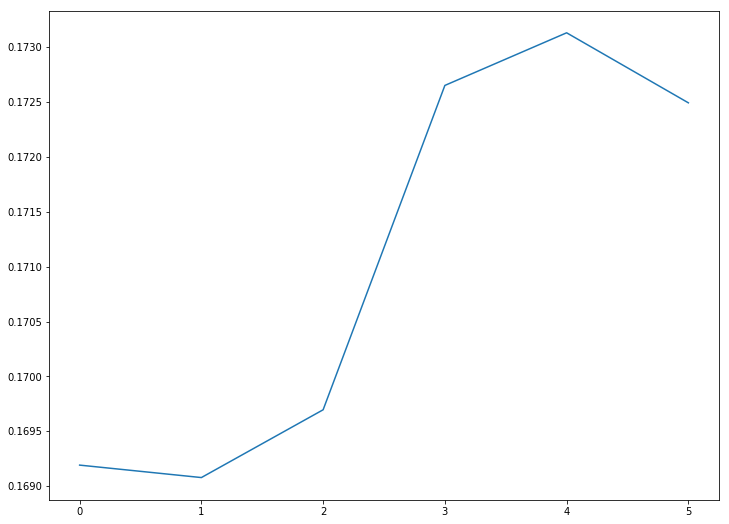

In [32]:
plt.plot(np.mean(f, axis=1))
plt.show()

In [42]:
nn = get_nn_model('simple', 'fc', metric='r2', verbose=True)

SavedModels/simple_best_fc_r2.h5
loading fc...


In [43]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

# 1. Performance

**heatmaps:**

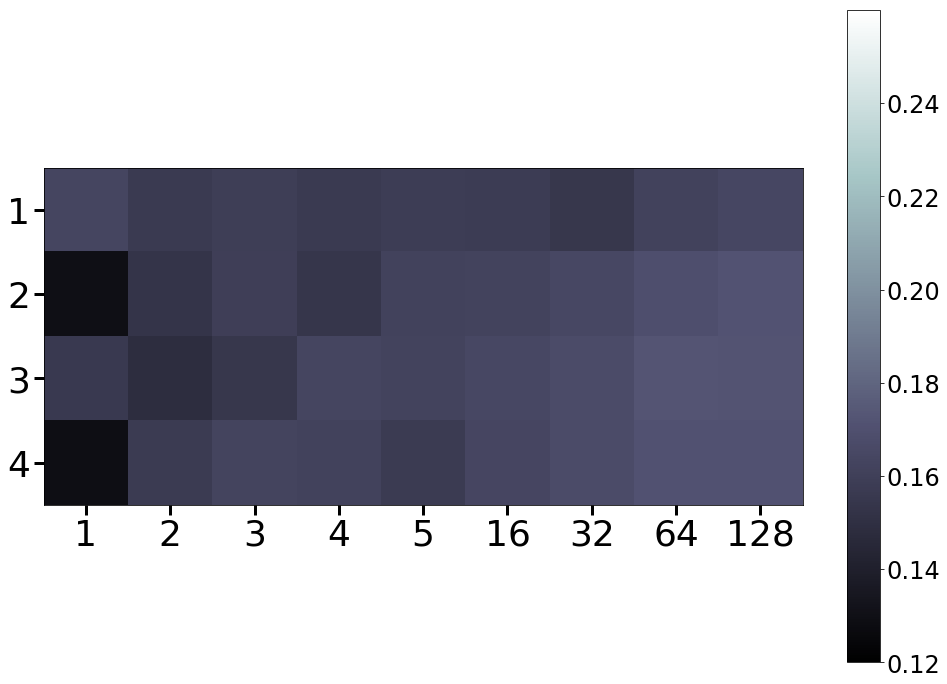

In [5]:
plt.rcParams['font.size'] = 24
ctype = 'simple'
mtype = 'fc'
metric = 'r2'

ndepths = hparams[mtype]['ndepths']
nwidths = hparams[mtype]['nwidths']
hidden_sizes = hparams[mtype]['h_sizes']
hidden_layers = hparams[mtype]['h_layers']


lims = {'simple':{'bps':(.35,.75), 'r2':(.12,.26)}, 'complex':{'bps':(0.,.6), 'r2':(0.0,.20)}}
step = {'bps':.05, 'r2':.02}
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype]),
        'istac':(5,1,cell_nums[ctype]), 'cbf':(5,3,cell_nums[ctype]), 'rbf':(3,3,cell_nums[ctype])} # rnn is 3x4 for complex
labels = {'r2':'$r^2$', 'bps': '$I_{ss}$' }

order = 'C' if mtype in nn_models else 'F'


data = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',').reshape(shape[mtype], order=order)
avg_data = np.mean(data, axis=2)
avg_data = avg_data.T if mtype in lnp_models else avg_data
plt.imshow(avg_data, 'bone', vmin=lims[ctype][metric][0], vmax=lims[ctype][metric][1], interpolation='nearest')

#plt.colorbar(orientation="vertical",fraction=0.1,
 #            ticks=np.arange(lims[ctype][metric][0], .25, step[metric]),
  #           label='') #labels[metric] #lims[ctype][metric][1]+step[metric]
plt.tick_params(length=10.0, width=3.0)

plt.xticks(np.arange(nwidths), hidden_sizes, fontsize=36)
xlab = 'Width (units per hidden layer)' if mtype in nn_models else 'Filters'
#plt.xlabel(xlab, fontsize=34, fontweight='bold')

plt.yticks(np.arange(ndepths), [1,2,3,4], fontsize=36)#hidden_layers
#plt.tick_params(labelsize=18)
ylab  = 'Depth (no. of layers)' if mtype in nn_models else 'Basis Functions'
#plt.ylabel(ylab, fontsize=34, fontweight='bold')

#plt.title('{}'.format(mtype.upper()), fontsize=44, fontweight='bold')
#plt.savefig('/Users/TedMoskovitz/Thesis/Figures/cnn_simple_heatmap.pdf')
plt.show()

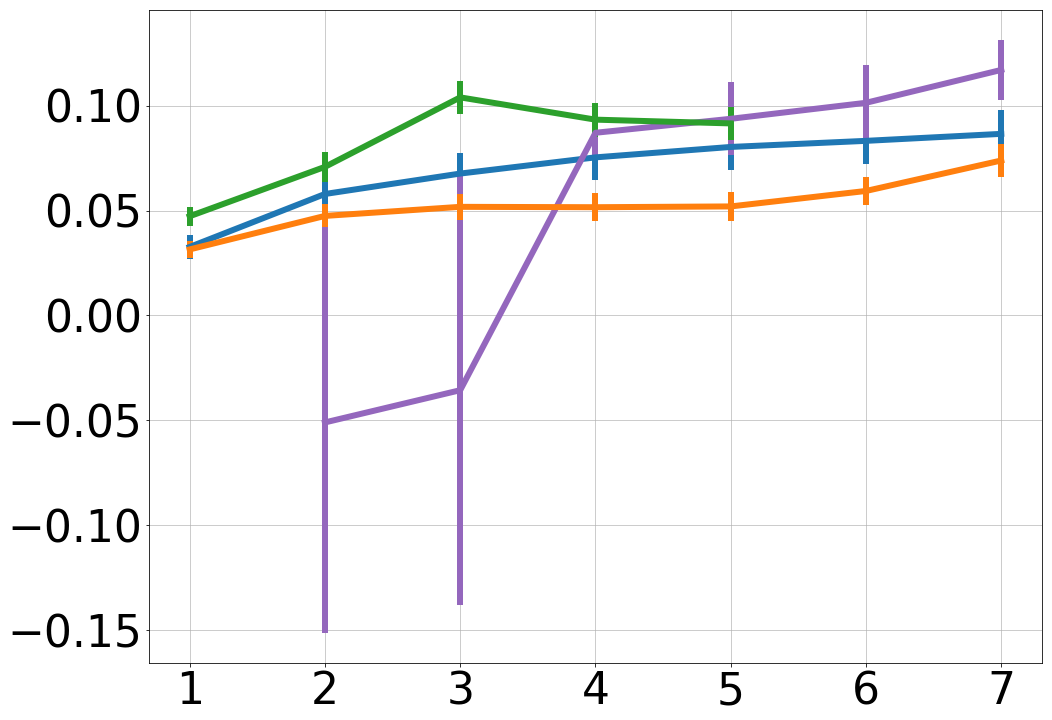

In [262]:
c_nums = {'simple':3, 'complex':9}
plt.rcParams['font.size'] = 44

celltype = 'complex'
metric = 'r2'
sc = .3
lw = 6
f = '-'
c = .01 # complex

nlin = 'cbf'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype], order='F')

means = np.mean(perf, axis=1)
stds = np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='-',
             label='iSTAC', color='C0', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/es_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype])


means = np.mean(perf, axis=1)
stds = np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0]-1)+2, means[1:], yerr=stds[1:], fmt='-',
             label='ES', color='C4', linewidth=lw)


nlin = 'istac'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(5,2,c_nums[celltype], order='F')

means = np.mean(perf[:,0,:], axis=1)
stds = np.std(perf[:,0,:], axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='-',
             label='CBF', color='C2', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/istac_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype]) + .02


means = np.mean(perf, axis=1)
stds = np.std(perf, axis=1)

plt.errorbar(np.arange(perf.shape[0])+1, means, yerr=stds, fmt='-',
             label='DNN', color='C1', linewidth=lw)

#, capsize=14, elinewidth=5, markeredgewidth=4

plt.grid(alpha=0.8)
plt.xticks(np.arange(perf.shape[0])+1)
#plt.ylim([0.112, 0.219])

#plt.legend(loc='lower right', fontsize=18)
#plt.title('{} Cell Population'.format(celltype[0].upper() + celltype[1:]), fontsize=44, fontweight='bold')
plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_pop_filt_perf.pdf'.format(celltype))
plt.show()

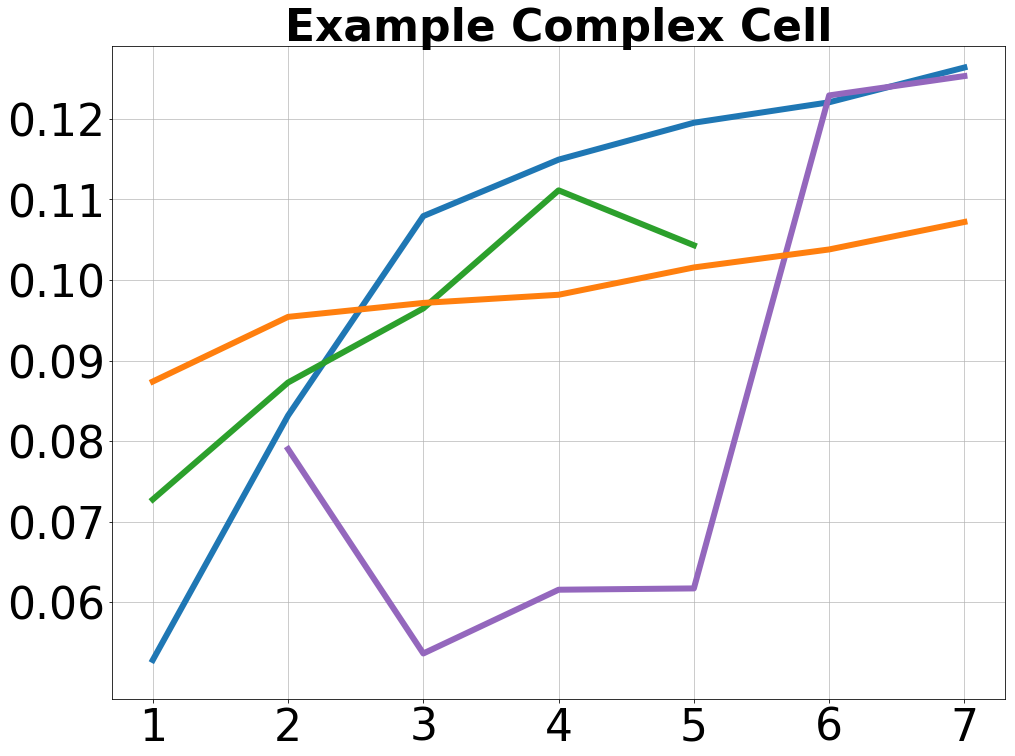

In [210]:
c_nums = {'simple':3, 'complex':9}
plt.rcParams['font.size'] = 44
lw = 6

celltype = 'complex'
metric = 'r2'

nlin = 'cbf'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype], order='F')

vals = perf[:,0] 

plt.plot(np.arange(perf.shape[0])+1, vals, label='iSTAC', color='C0', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/es_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype])


vals = perf[:,0]

plt.plot(np.arange(perf.shape[0]-1)+2, vals[1:], label='ES', color='C4', linewidth=lw)


nlin = 'istac'
path = 'SavedResults/' + celltype + '_' + nlin + '_' + metric + '.csv'
perf = np.genfromtxt(path, delimiter=',').reshape(5,2,c_nums[celltype], order='F') #+  .09

vals = perf[:,0,0] 

plt.plot(np.arange(perf.shape[0])+1, vals, label='CBF', color='C2', linewidth=lw)


nlin = 'fc'
path = 'SavedResults/istac_tr_' + celltype + '_' + nlin + '_' + metric + '.csv'
perf =  np.genfromtxt(path, delimiter=',').reshape(7,c_nums[celltype]) #+ .06

# complex:
vals = perf[:,0] 

plt.plot(np.arange(perf.shape[0])+1, vals, label='DNN', color='C1', linewidth=lw)


plt.grid(alpha=0.8)

#plt.yticks([.27, .28, .29])
#plt.ylim([.267, .295]) #simple
plt.xticks(np.arange(perf.shape[0])+1)
plt.ylim([0.048, 0.129]) # complex
plt.yticks([0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12])

#plt.ylabel('Test $r^2$', fontsize=44, fontweight='bold')
plt.title('Example {} Cell'.format(celltype[0].upper() + celltype[1:]), fontsize=44, fontweight='bold')

#plt.legend(loc='lower right', fontsize=40)

plt.savefig('/Users/TedMoskovitz/Thesis/Figures/{}_filt_perf.pdf'.format(celltype))
plt.show()

In [54]:
np.where(data==np.max(data))

(array([1]), array([4]), array([3]))

In [10]:
s = V1(ctype, 2)
print s.r2

building data...
fetching repeat data...
done.
0.23088328580896952


**bar charts:**

In [15]:
def errorfill(x, y, yerr, color='C0', alpha_fill=0.1, ax=None, label=None):
    ax = ax if ax is not None else plt.gca()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, ':', color=color, label=label, lw=5.)
    #ax.set_ylabel(r'fitness')
    #ax.set_xlabel(r'evaluations')
    ax.tick_params(axis='both', labelsize=20)
    #ax.grid(alpha=0.7)
    ax.legend(fontsize=22)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [6]:
ctype = 'simple'
metric = 'r2'

rpt_r2s = []
for c in range(cell_nums[ctype]):
    v1 = V1(ctype, c+1, verbose=False)
    rpt_r2s.append(v1.r2)
    

models = ['istac', 'cbf', 'fc', 'rnn', 'cnn']
#models = ['istac', 'cbf', 'rbf', 'fc', 'rnn', 'cnn', 'cnn_filt']
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype])} 
filt_shape = {'simple':{'fc_filt':(6,cell_nums[ctype]), 'cnn_filt':(6,cell_nums[ctype])},
              'complex':{'fc_filt':(5,cell_nums[ctype]), 'cnn_filt':(5,cell_nums[ctype])}}

means = []
stds = []

for mtype in models:
    print (mtype)
    prefix = './SavedResults/'
    if mtype in filt_models: path = 'filts_' + ctype + '_' + mtype[:-5] + '_' + metric + '.csv';
    else: path = ctype + '_' + mtype + '_' + metric + '.csv'
    data = np.genfromtxt(prefix + path, delimiter=',')
    if mtype in nn_models:
        ndepths = hparams[mtype]['ndepths']
        nwidths = hparams[mtype]['nwidths']
        hidden_sizes = hparams[mtype]['h_sizes']
        hidden_layers = hparams[mtype]['h_layers']
        data = data.reshape(shape[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    elif mtype in filt_models:
        shape = filt_shape[ctype][mtype]
        data = data.reshape(shape)
        data_mean = np.mean(data, axis=1)
        data_std = np.mean(data, axis=1)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0]])
        stds.append(data_std[loc[0][0]])
    else:
        data_mean = np.mean(data, axis=0)
        means.append(data_mean)
        data_std = np.std(data, axis=0)
        stds.append(data_std) #[-1]


istac
cbf
fc
rnn
cnn


In [7]:
es_path = './SavedResults/es_tr_simple_fc_r2.csv'
es_r2 = np.genfromtxt(es_path, delimiter=',')
print (es_r2.shape)

(7, 3)


In [8]:
mu_es = np.mean(es_r2[-1,:]) #-.01
std_es = np.std(es_r2[-1,:])

In [9]:
means.insert(1, mu_es)
stds.insert(1, std_es)
models.insert(1, 'es')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


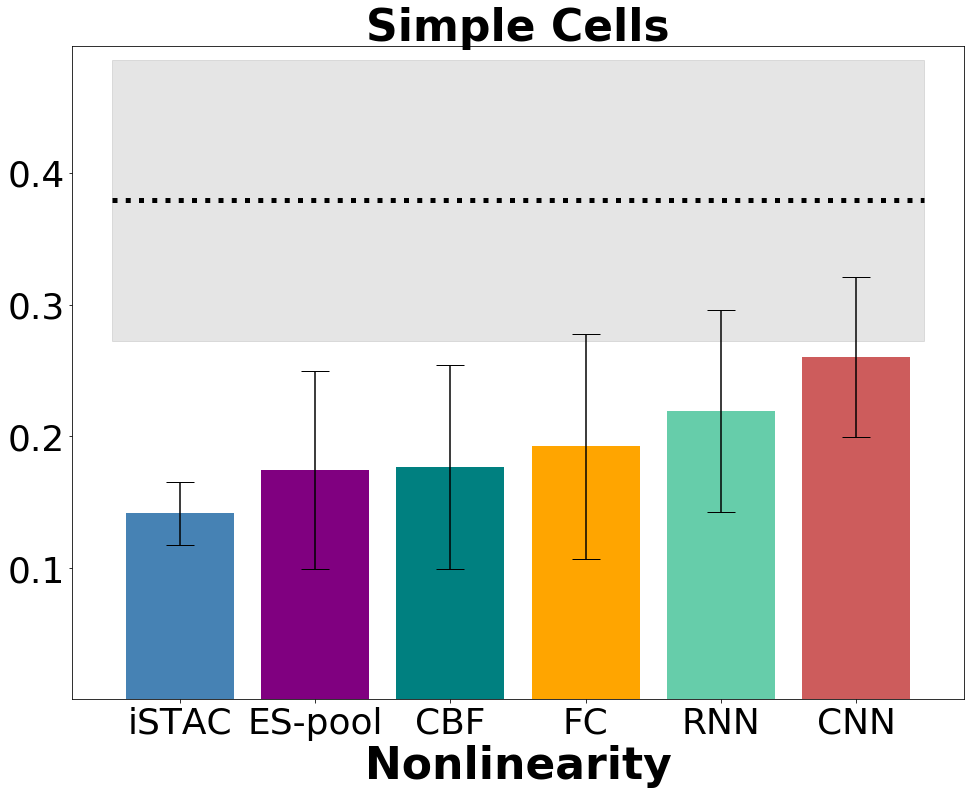

In [19]:
# plot r2
#models = models[:-1]
#means = means[:-1]
#stds = stds[:-1]
plt.rcParams['font.size'] = 24
colors = ['steelblue',  'purple', 'teal', 'orange', 'mediumaquamarine', 'indianred']
cs = colors[:len(models)]
tlabels = [m.upper() for m in models]
tlabels[0] = 'iSTAC'
tlabels[1] = 'ES-pool'
X = np.linspace(1.,3.,num=len(models))
plt.bar(X, means, width=.32, yerr=stds, tick_label=tlabels, color=cs, capsize=14)
#plt.plot([.8, 3.2], [np.mean(rpt_r2s),np.mean(rpt_r2s)], ":", lw=5.,label='mean repeat $r^2$', color='black')

r2_mean = np.array([np.mean(rpt_r2s), np.mean(rpt_r2s)])
r2_std = np.array([np.std(rpt_r2s), np.std(rpt_r2s)])
errorfill([.8, 3.2], r2_mean, r2_std, color='black')

#plt.legend(loc='upper right', fontsize=27, framealpha=0.4)
plt.xlabel('Nonlinearity', fontsize=44, fontweight='bold')
#plt.ylabel('Test $r^2$', fontsize=44)
plt.tick_params(labelsize=36)
plt.ylim([0.001,np.mean(rpt_r2s)+np.std(rpt_r2s)+.01])
plt.yticks([0.1, 0.2, 0.3, 0.4])
plt.title('%s Cells' % (ctype[0].upper()+ctype[1:]), fontsize=44, fontweight='bold')
plt.savefig('/Users/TedMoskovitz/Thesis/Figures/simple_r2_bar_err.pdf')
plt.show()

/Users/TedMoskovitz/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


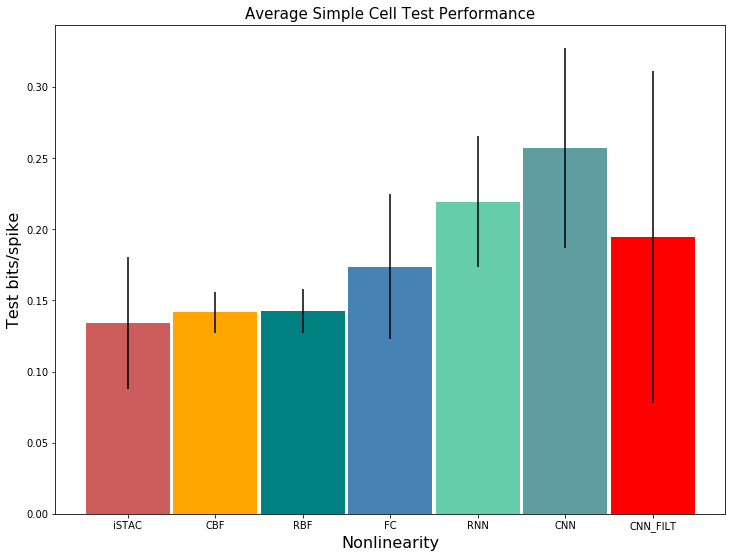

In [83]:
# plot bps
colors = ['indianred',  'orange', 'teal', 'steelblue', 'mediumaquamarine', 'cadetblue', 'red']
cs = colors[:len(models)]
tlabels = [m.upper() for m in models]
tlabels[0] = 'iSTAC'
X = np.linspace(1.,3.,num=len(models))
plt.bar(X, means, width=.32, yerr=.6*np.asarray(stds), tick_label=tlabels, color=cs)
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test bits/spike', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

In [84]:
s = 'hello'
print (s.endswith('lo'))

True


In [244]:
ctype = 'simple'
metric = 'bps'

rpt_r2s = []
for c in range(cell_nums[ctype]):
    v1 = V1(ctype, c+1, verbose=False)
    rpt_r2s.append(v1.r2)
    

#models = ['fc', 'rnn', 'cnn', 'istac', 'cbf', 'rbf']
models = ['fc_istac', 'es', 'fc_istac_tr', 'fc_filt', 'fc']
shapes = {'fc':(4,9,cell_nums[ctype]), 'fc_istac':(6,cell_nums[ctype]),
         'fc_istac_tr':(7,cell_nums[ctype]), 'fc_filt':(7,cell_nums[ctype]),
         'es':(4,4,cell_nums[ctype])}

filt_models = ['fc_filt', 'cnn_filt']


means = []
stds = []

for mtype in models:
    prefix = './SavedResults/'
    path = ''
    m = mtype
    print (mtype)
    if mtype.endswith('_istac'): path = 'istac_filts_'; m = m[:-6];
    if mtype.endswith('_istac_tr'): path = 'istac_tr_'; m = m[:-9];
    if mtype.endswith('_filt'): path = 'filts_'; m = m[:-5];
    if mtype.startswith('es'): path = 'es_'; m = 'fc'; 
    path += ctype + '_' + m + '_' + metric + '.csv'
    data = np.genfromtxt(prefix + path, delimiter=',')
    
    if mtype in nn_models:
        ndepths = hparams[mtype]['ndepths']
        nwidths = hparams[mtype]['nwidths']
        hidden_sizes = hparams[mtype]['h_sizes']
        hidden_layers = hparams[mtype]['h_layers']
        data = data.reshape(shapes[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    elif mtype =='es':
        data = data.reshape(shapes[mtype])
        data_mean = np.mean(data, axis=2)
        data_std = np.std(data, axis=2)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0], loc[1][0]])
        stds.append(data_std[loc[0][0], loc[1][0]])
    else:
        shape = shapes[mtype]
        data = data.reshape(shape)
        data_mean = np.mean(data, axis=1)
        data_std = np.mean(data, axis=1)
        loc = np.where(data_mean == np.max(data_mean))
        means.append(data_mean[loc[0][0]])
        stds.append(data_std[loc[0][0]])




fc_istac
es
fc_istac_tr
fc_filt
fc


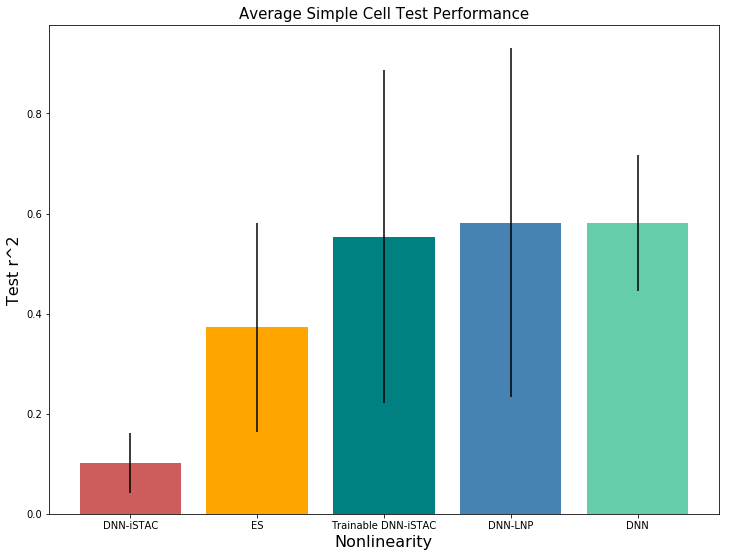

In [111]:
# plot r^2
colors = ['indianred', 'orange', 'teal', 'steelblue', 'mediumaquamarine']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES', 'Trainable DNN-iSTAC', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,2.6,num=len(models))
plt.bar(X, means, width=.32, yerr=.6*np.asarray(stds), tick_label=tlabels, color=cs)
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=16)
plt.ylabel('Test r^2', fontsize=16)
plt.title('Average %s Cell Test Performance' % (ctype[0].upper()+ctype[1:]), fontsize=15)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


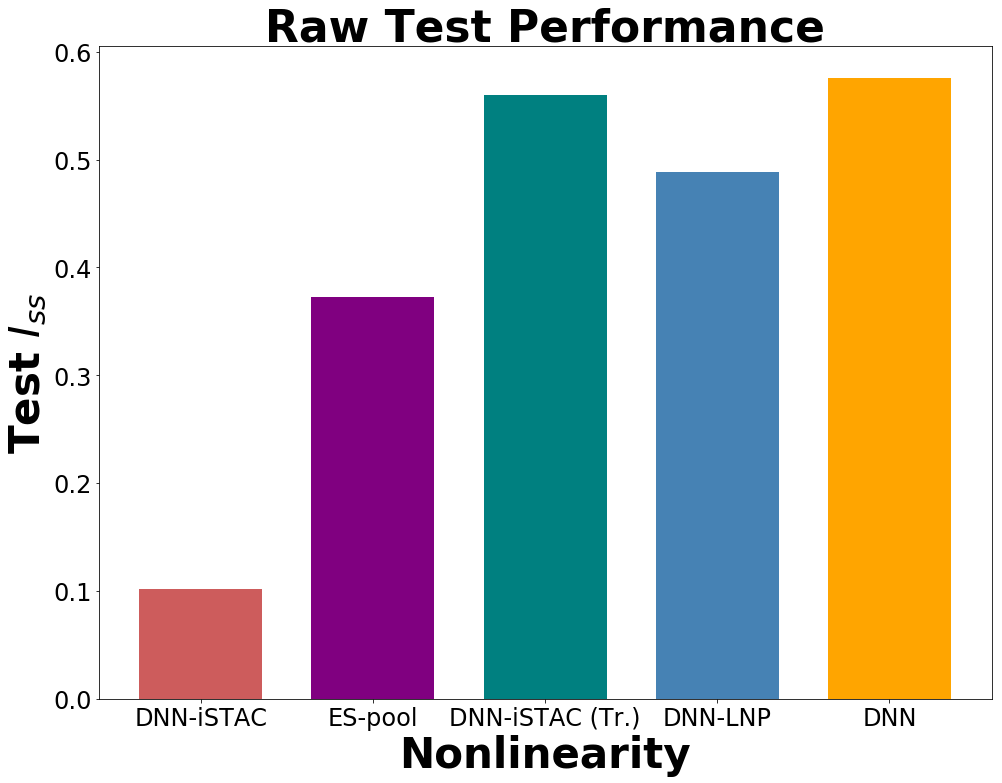

In [253]:
# plot bps
colors = ['indianred',  'purple', 'teal', 'steelblue', 'orange', 'mediumaquamarine', 'red']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES-pool','DNN-iSTAC (Tr.)', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,15.,num=len(models))
plt.bar(X, means, width=2.5, tick_label=tlabels, color=cs) #yerr=.3*np.asarray(stds),
plt.tick_params(labelsize=24)
plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=42, fontweight='bold')
plt.ylabel('Test $I_{ss}$', fontsize=42, fontweight='bold')
plt.title('Raw Test Performance', fontsize=44, fontweight='bold')
plt.savefig('/Users/TedMoskovitz/Thesis/Figures/bps_raw.pdf')
plt.show()

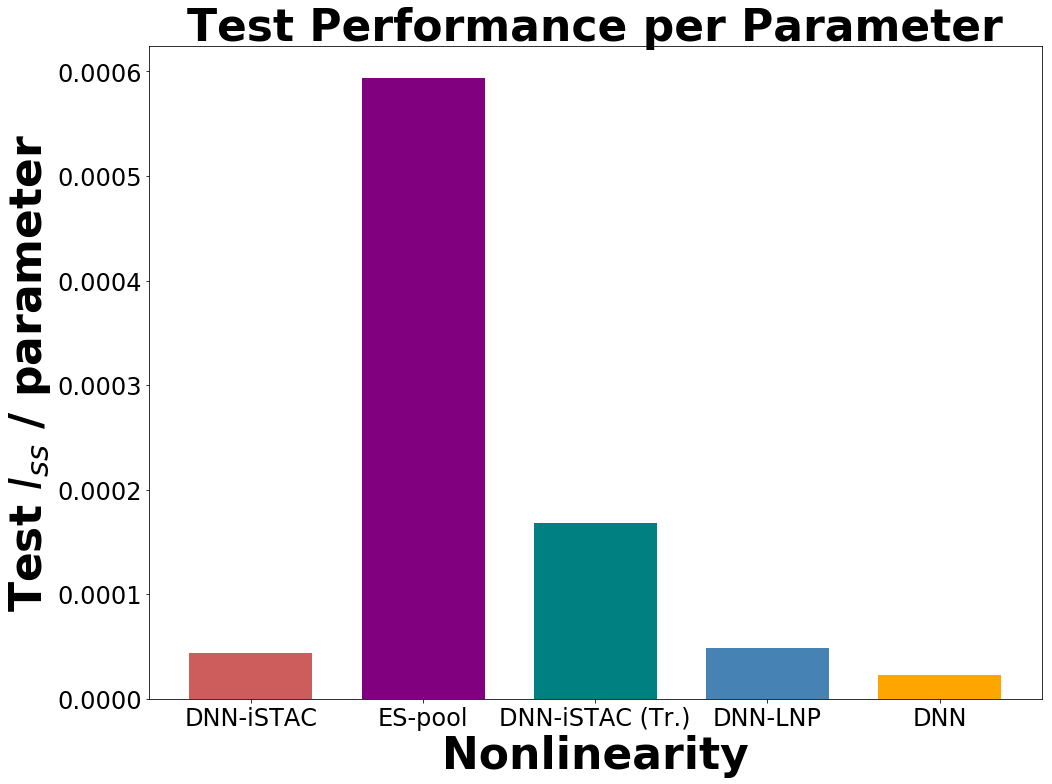

In [257]:
# plot bps/param
param_ns = {'fc_istac':2305, 'es':627, 'fc_istac_tr':3333, 'fc_filts':10054, 'fc':24833}
p_ns = [2305, 627, 3333, 10054, 24833]
means_pp = [m/p for m,p in zip(means, p_ns)]
colors = ['indianred',  'purple', 'teal', 'steelblue', 'orange', 'cadetblue', 'red']
cs = colors[:len(models)]
tlabels = ['DNN-iSTAC', 'ES-pool','DNN-iSTAC (Tr.)', 'DNN-LNP', 'DNN']#[m.upper() for m in models]
X = np.linspace(1.,15.,num=len(models))
plt.bar(X, means_pp, width=2.5, tick_label=tlabels, color=cs) #yerr=.3*np.asarray(stds),
plt.tick_params(labelsize=24)
#plt.legend(loc='upper right')
plt.xlabel('Nonlinearity', fontsize=44, fontweight='bold')
plt.ylabel('Test $I_{ss}$ / parameter', fontsize=44, fontweight='bold')
plt.title('Test Performance per Parameter', fontsize=44, fontweight='bold')
plt.savefig('/Users/TedMoskovitz/Thesis/Figures/bps_per_param.pdf')
plt.show()

In [24]:
len(means)

3

# 2. PSTHs

In [8]:
def plot_psth(models, celltype, cell_num, metric='r2', data=None, window=(0,-1)):
    #cell_num = np.where(data==np.max(data))[2][0]+1 if data is not None else 
    v1 = V1(celltype, cell_num, verbose=False)
    plt.imshow(v1.rpt_raster[:,window[0]:window[1]])
    plt.ylabel('Repeat #')
    plt.title('Raster')
    plt.show()
    
    
    plt.plot(v1.psth[window[0]:window[1]], label='Repeat Data', color='black')
    
    
    for m in models:
        flatten = True if m=='fc' else False
        v1 = V1(celltype, cell_num, flatten=flatten, verbose=False)
        if m in nn_models:
            nn = get_nn_model(celltype, m, metric=metric, verbose=False)
            rpt_preds = nn.predict(v1.X_rpt)
        elif m in lnp_models:
            rpt_preds = np.asarray(eng.lnp_predict(celltype, m, v1.rpt_file)) 
        model_psth = v1.convert_psth(rpt_preds)
        plt.plot(model_psth[window[0]:window[1]], label=m.upper() if not m =='istac' else 'iSTAC')

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Spike Count', fontsize=14)
    plt.legend(fontsize=14)
    plt.title('PSTH for %s Cell' % (celltype[0].upper()+celltype[1:]), fontsize=16)
    plt.show()

In [21]:
m = 'cnn'
celltype = 'simple'
flatten = False
metric = 'bps'
cell_num = 1

v1 = V1(celltype, cell_num, flatten=flatten, verbose=False)
nn = get_nn_model(celltype, m, metric=metric, verbose=False)

SavedModels/simple_best_cnn_bps.h5


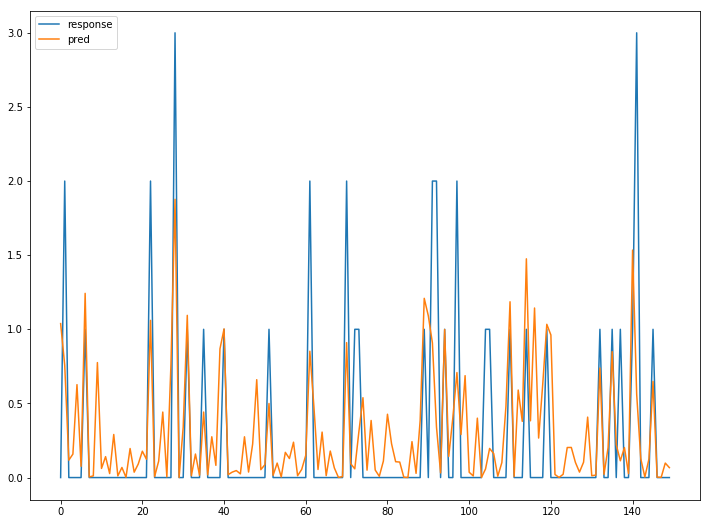

In [27]:
lo = 100
hi = 250
plt.plot(v1.y_test[lo:hi], label='response')
plt.plot(nn.predict(v1.X_test[lo:hi]), label='pred')
plt.legend()
plt.show()

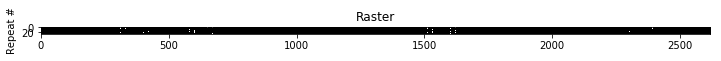

SavedModels/simple_best_cnn_bps.h5


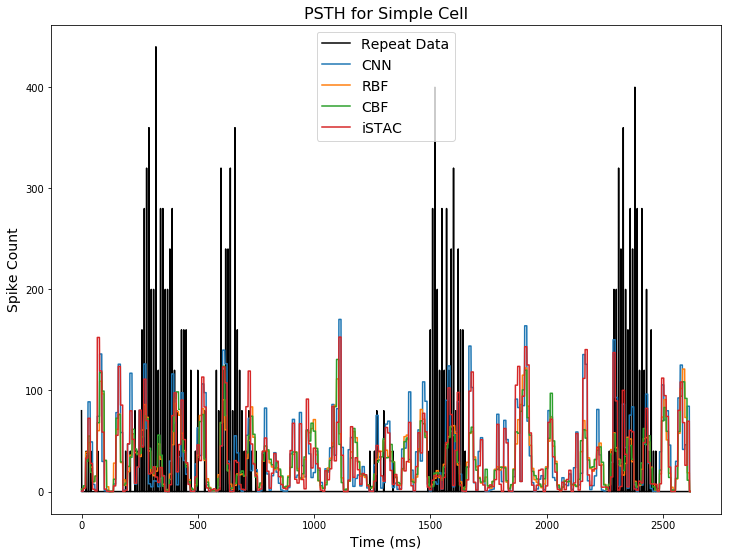

In [26]:
models = ['cnn', 'rbf', 'cbf', 'istac']
ctype = 'simple'
plot_psth(models, ctype, 1, metric='bps', window=(2500,-1))

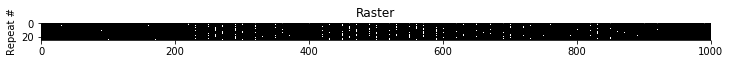

SavedModels/complex_best_cnn_r2.h5


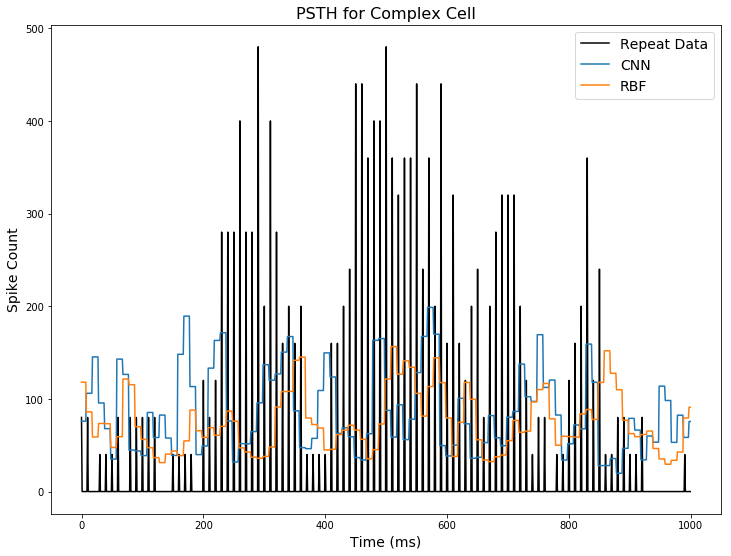

In [12]:
models = ['cnn', 'rbf']
ctype = 'complex'
plot_psth(models, ctype, 4, metric='r2', window=(2000,3000))

# Filters/Weights

In [3]:
def get_nn_wts(model, celltype, metric='r2', verbose=False, filts=False):
    nn = get_nn_model(celltype, model, metric=metric, verbose=verbose, filts=filts) 
    if verbose: nn.summary(); 
    weights = [l.get_weights() for l in nn.layers]
    return weights

def get_filts(wts):
    return wts[0][0]

In [32]:
m = load_model('SavedModels/es_tr_complex_best_fc_r2.h5', custom_objects={'poiss_full':poiss_full})

In [139]:
wts = get_nn_wts('fc', 'complex', metric='r2',verbose=True, filts=False)

loading fc...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_252 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 129       
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [140]:
filts = get_filts(wts)

In [141]:
filts.shape

(256, 128)

In [37]:
wts = [l.get_weights() for l in m.layers]
E = wts[1][0]
S = wts[2][0]
stc = np.genfromtxt('SavedResults/complex_stc4.csv', delimiter=',')
U,V = np.linalg.eig(stc)
print ('Median eigenvalue of STC:')
print (np.median(U))
print ('Excitatory:')
for i in range(E.shape[1]):
    w = E[:,i].reshape(-1,1)
    print (np.dot(np.dot(w.T, stc), w))
    
print ('Suppressive:')
for i in range(S.shape[1]):
    w = S[:,i].reshape(-1,1)
    print (np.dot(np.dot(w.T, stc), w))

Median eigenvalue of STC:
0.994819285293
Excitatory:
[[ 0.94086936]]
[[ 0.87732293]]
[[ 1.44467164]]
Suppressive:
[[ 1.57132933]]
[[ 1.07177174]]
[[ 1.8041716]]
[[ 1.28897014]]


In [ ]:
def pca_reduce(filts, i):
    X = filts.reshape(-1,128)
    X -= np.mean(X, axis = 0) # zero-center the data (important)
    cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(X, U) # decorrelate the data
    Xrot_reduced = np.dot(X, U[:,:i]) # Xrot_reduced becomes [N x i]
    return Xrot_reduced

In [ ]:
model = Sequential()
model.add(Dense(LNP, weights=[filts, np.zeros(LNP)],
                              trainable=trainable, input_dim=dim, activation='softplus', name='istac_filts'))

In [135]:
X = filts.reshape(-1,32)
X -= np.mean(X, axis = 0) # zero-center the data (important)
cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
U,S,V = np.linalg.svd(cov)
Xrot = np.dot(X, U) # decorrelate the data
Xrot_reduced = np.dot(X, U[:,:10]) # Xrot_reduced becomes [N x 100]

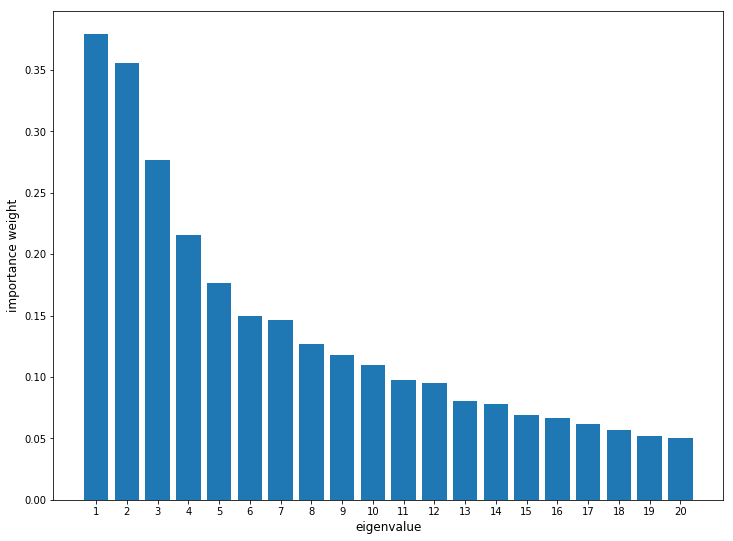

In [136]:
n = 20
plt.bar(np.arange(n)+1, S[:n])
plt.xticks(np.arange(n)+1)
plt.xlabel('eigenvalue', fontsize=12)
plt.ylabel('importance weight', fontsize=12)
plt.show()

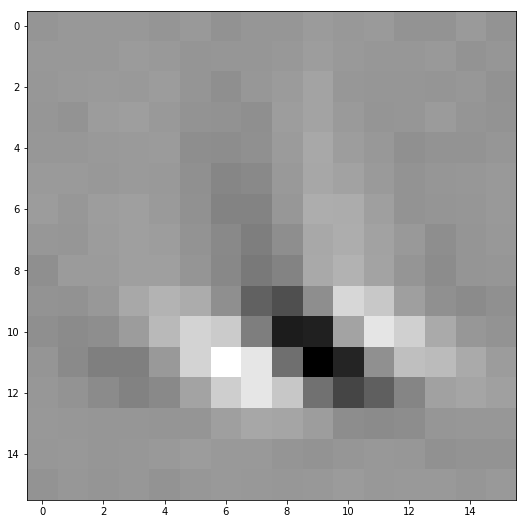

In [143]:
plt.imshow(Xrot_reduced[:,0].reshape(16,16), interpolation='nearest')
plt.show()

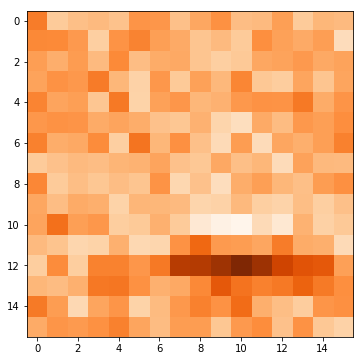

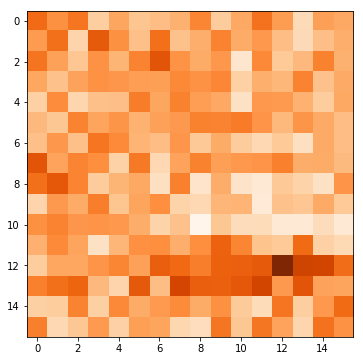

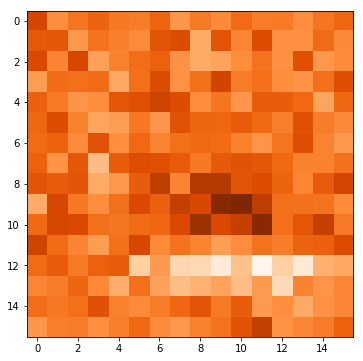

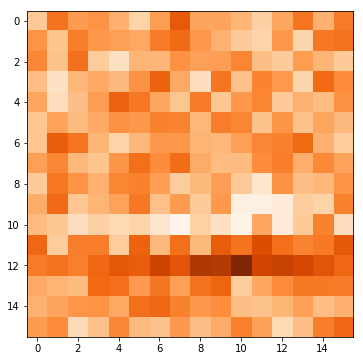

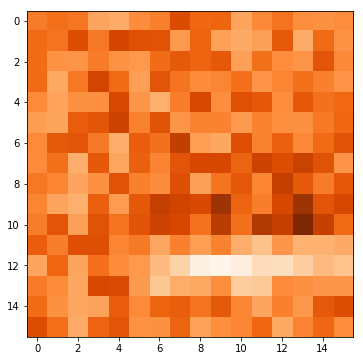

In [17]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
filts = get_filts(wts)

for i in range(filts.shape[1]):
    f = filts[:,i].reshape(-1,16)
    plt.imshow(f/np.linalg.norm(f), interpolation='nearest', cmap='Oranges')
    plt.show()

LNP Filters

In [181]:
model = 'cbf'
ctype = 'complex'

lnp_filts = np.asarray(eng.get_filters(ctype, model))

In [182]:
lnp_filts.shape

(16, 16, 5)

In [183]:
X = lnp_filts.reshape(-1,5)
X -= np.mean(X, axis = 0) # zero-center the data (important)
cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
U,S,V = np.linalg.svd(cov)
Xrot = np.dot(X, U) # decorrelate the data
Xrot_reduced = np.dot(X, U[:,:10]) # Xrot_reduced becomes [N x 100]

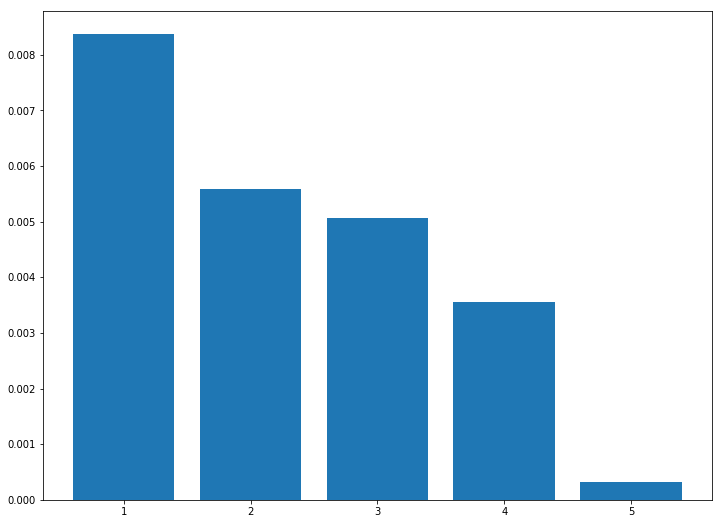

In [184]:
n = 5
plt.bar(np.arange(n)+1, S[:n])
plt.xticks(np.arange(n)+1)
plt.show()

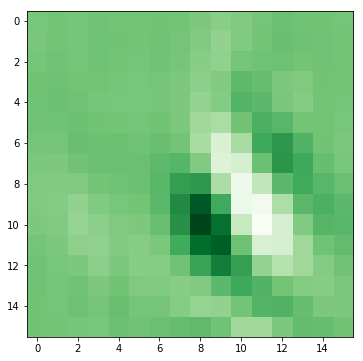

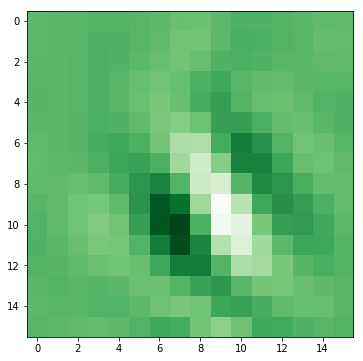

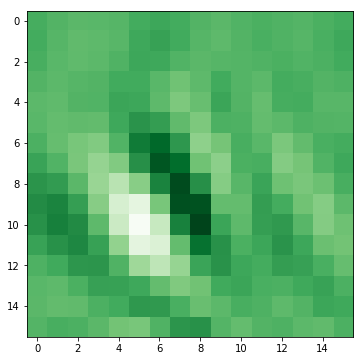

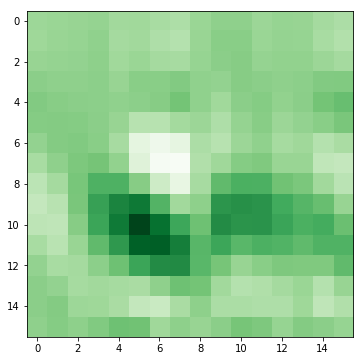

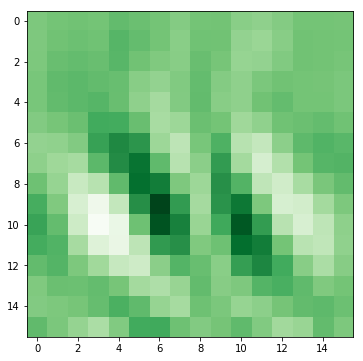

In [65]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
for i in range(lnp_filts.shape[2]):
    f = lnp_filts[:,:,i]
    plt.imshow(f/np.linalg.norm(f), interpolation='nearest', cmap='Greens') # cmap = Blues for iSTAC, Greens for R/CBF
    plt.show()

In [51]:
cbf = np.genfromtxt('SavedFilters/complex_cbf_filters_cell1.csv', delimiter=',')

IOError: SavedFilters/complex_cbf_filters_cell1.csv not found.

In [49]:
cbf = np.reshape(cbf, [16,16,5], order='F')

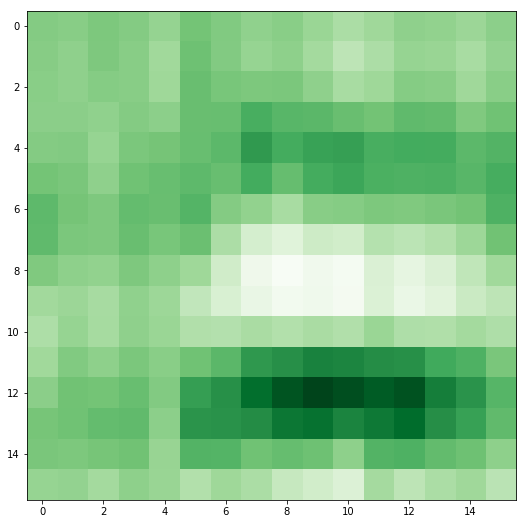

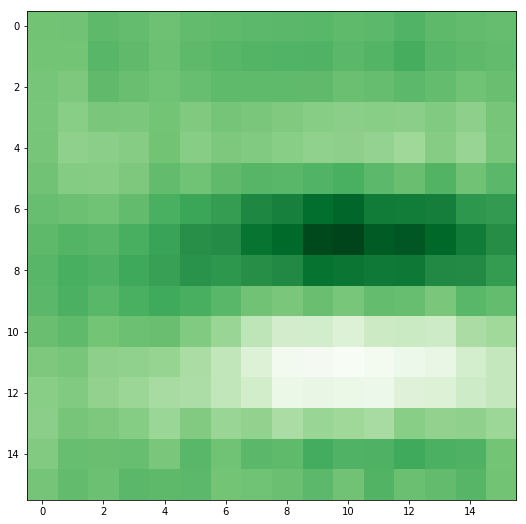

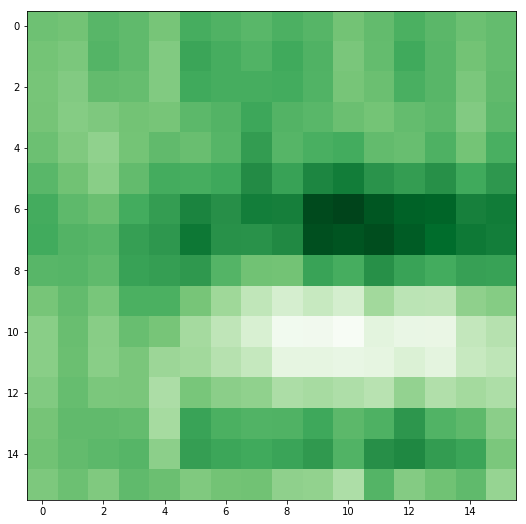

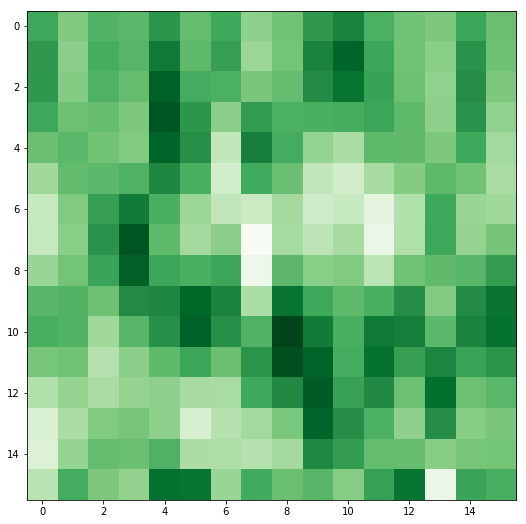

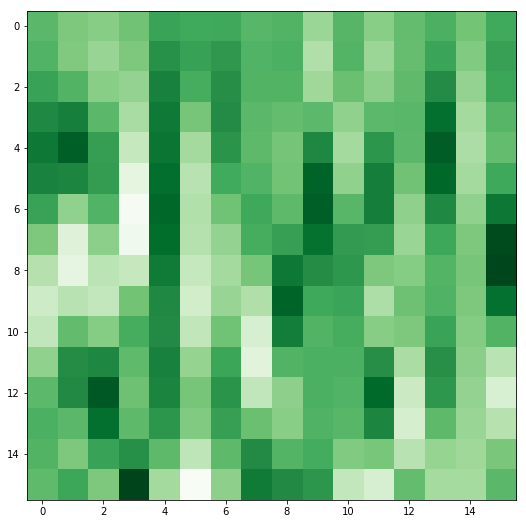

In [50]:
for i in range(5):  
    f = cbf[:,:,i] 
    plt.imshow(f / np.linalg.norm(f), interpolation='nearest', cmap='Greens')
    plt.show()

# Nonlinearities

In [258]:
import nonlinearity as nl

def get_lnp_nlin(celltype, nlin):
    return np.genfromtxt('./SavedNonlins/' + celltype + '_' + nlin + '.csv', delimiter=',')

In [259]:
celltype = 'simple'
path = 'SavedModels/2f_es_tr_' + celltype + '_best_fc_r2.h5'
#path = 'SavedModels/2_filts_' + celltype + '.h5'
model = load_model(path, custom_objects={'poiss_full': poiss_full})

In [260]:
x,y,z = nl.generate(model, bound=2.5, es=True)

50000 / 250000 points computed
100000 / 250000 points computed
150000 / 250000 points computed
200000 / 250000 points computed


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


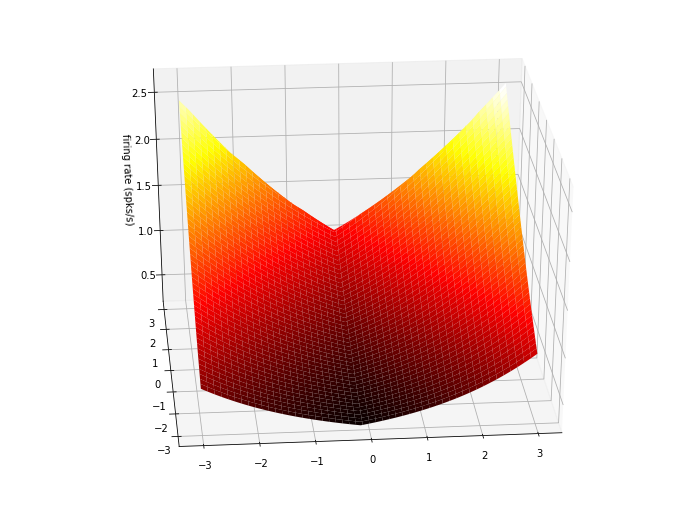

In [17]:
nl.plot([x,y,z], rot=265, cmap='hot')

In [7]:
import keras
print keras.__version__

2.0.9


In [21]:
celltype = 'simple'
z_lnp = np.asarray(eng.nonlinearity(celltype, 'cbf', 2.5))

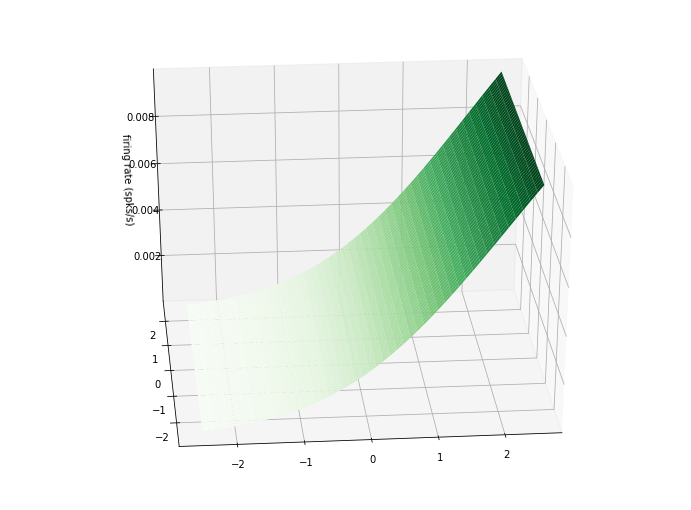

In [23]:
nl.plot([x, y, z_lnp], rot=265, cmap='Greens') #.0025 istac # .02 istac complex, .015 rbf complex, .02 cbf complex

# real ES

**performance**

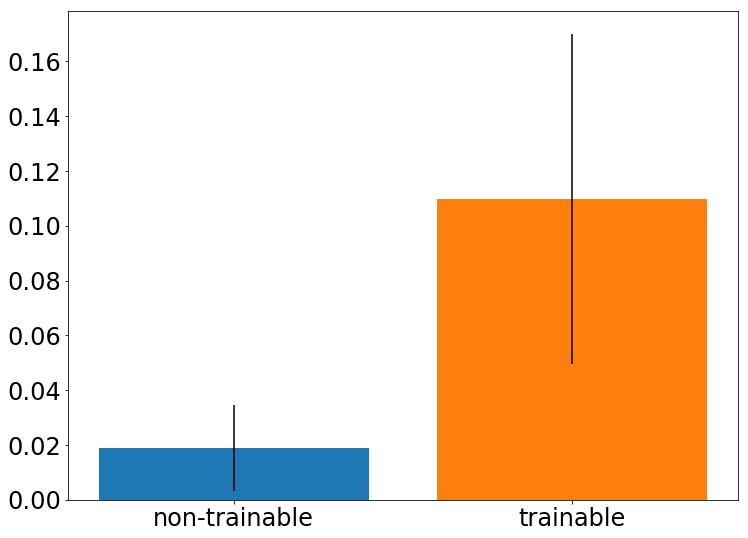

In [36]:
celltype = 'complex'
metric = 'r2'

means = []
stds = []

train1 = False
ext1 = 'tr_' if train1 else ''
path = 'SavedResults/real_es_' + ext1 + celltype + '_' + 'fc_' + metric + '.csv'
perf_nt = np.genfromtxt(path, delimiter=',')
means.append(np.mean(perf_nt))
stds.append(np.std(perf_nt))


train2 = True
ext2 = 'tr_' if train2 else ''
path = 'SavedResults/real_es_' + ext2 + celltype + '_' + 'fc_' + metric + '.csv'
perf_t = np.genfromtxt(path, delimiter=',')

means.append(np.mean(perf_t))
stds.append(np.std(perf_t))

tlabels = ['non-trainable', 'trainable']
colors = ['C0', 'C1']
plt.bar(np.arange(2), means, yerr=stds, tick_label=tlabels, color=colors)
plt.show()

**E/S switches**

In [42]:
celltype = 'complex'
n_filts = 0
n_flipped = 0
n_cells = {'simple':3, 'complex':9}
for c in range(1,n_cells[celltype]+1):
    print('loading model for cell {}/{}...'.format(c,n_cells[celltype]))
    m = load_model('SavedModels/real_es_tr_{}_fc_cell{}.h5'.format(celltype,c),
                   custom_objects={'poiss_full':poiss_full})
    weights = [l.get_weights() for l in m.layers]
    print ('done.')
    
    stc = np.genfromtxt('SavedFilters/{}_stc_cell{}.csv'.format(celltype, c), delimiter=',')
    S,V = np.linalg.eig(stc)
    med_eig = np.median(S)
    print ('median STC eigenvalue: ', med_eig)
    
    # get 'E' and 'S' filters
    E = weights[1][0]
    nE = E.shape[1]
    S = weights[2][0]
    nS = S.shape[1]
    nf = nE + nS
    n_filts += nf
    
    # check their responses
    # test E 
    for i in range(nE):
        f = E[:,i].reshape(-1,1)
        resp = np.dot(np.dot(f.T,stc), f)[0,0]
        is_flip = resp < med_eig
        n_flipped += int(is_flip)
        print ('response value for E filter {} = {}; flipped?: {}'.format(i+1,resp, is_flip))
        

    # test S
    for i in range(nS):
        f = S[:,i].reshape(-1,1)
        resp = np.dot(np.dot(f.T,stc), f)[0,0]
        is_flip = resp < med_eig
        n_flipped += int(is_flip)
        print ('response value for S filter {} = {}; flipped?: {}'.format(i+1,resp, is_flip))
        
print ('proportion flipped: {}'.format(float(n_flipped) / n_filts))    

loading model...
done.
median STC eigenvalue:  0.997357493802
response value for E filter 1 = 0.6163648326474547; flipped?: True
response value for E filter 2 = 0.9006550540791767; flipped?: True
response value for E filter 3 = 1.2089193866036534; flipped?: False
response value for E filter 4 = 0.8898453435137481; flipped?: True
response value for E filter 5 = 0.8714771056607803; flipped?: True
response value for E filter 6 = 0.8674578759520335; flipped?: True
response value for S filter 1 = 1.219049204566417; flipped?: False
response value for S filter 2 = 0.9047128762741745; flipped?: True
loading model...
done.
median STC eigenvalue:  0.987300408392
response value for E filter 1 = 0.456073557424301; flipped?: True
response value for E filter 2 = 1.7810664241161585; flipped?: False
response value for E filter 3 = 1.3012613551321421; flipped?: False
response value for S filter 1 = 0.7894839576519064; flipped?: True
response value for S filter 2 = 0.8298653851804069; flipped?: True
res

In [32]:
stc = np.genfromtxt('SavedFilters/{}_stc_cell{}.csv'.format(celltype, c), delimiter=',')
S,V = np.linalg.eig(stc)
med_eig = np.median(S)
print (med_eig)

0.99493242282


In [33]:
E = weights[1][0]
nE = E.shape[1]
S = weights[2][0]
nS = S.shape[1]

In [34]:
# test E
for i in range(nE):
    f = E[:,i].reshape(-1,1)
    resp = np.dot(np.dot(f.T,stc), f)
    print ('response value for E filter {} = {}; flipped?: {}'.format(i+1,resp, resp < med_eig))
    
# test S
for i in range(nS):
    f = S[:,i].reshape(-1,1)
    resp = np.dot(np.dot(f.T,stc), f)
    print ('response value for S filter {} = {}; flipped?: {}'.format(i+1,resp, resp > med_eig))

response value for E filter 1 = [[ 0.76090277]]; flipped?: [[ True]]
response value for E filter 2 = [[ 0.88898243]]; flipped?: [[ True]]
response value for S filter 1 = [[ 0.7010884]]; flipped?: [[False]]
response value for S filter 2 = [[ 1.16885074]]; flipped?: [[ True]]
response value for S filter 3 = [[ 1.01771005]]; flipped?: [[ True]]
response value for S filter 4 = [[ 1.04991835]]; flipped?: [[ True]]
response value for S filter 5 = [[ 1.10387819]]; flipped?: [[ True]]
response value for S filter 6 = [[ 1.06821532]]; flipped?: [[ True]]
